In [1]:
!pip install pandas numpy matplotlib yfinance ipywidgets==8.0.6


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import yfinance as yf
import ipywidgets as widgets
from datetime import datetime, timedelta
import os

## Functions

Define useful functions to work with datasets properly:

In [3]:
# ------------------------------------------------------------------------------------------------------------------
# READ DATA
# ------------------------------------------------------------------------------------------------------------------
def read_dataset(index, interval, start_year, save=False):
    yf_tickers = {'sp500': '^GSPC', 'nasdaq': 'QQQ'}
    yf_intervals = {'daily': '1d', 'monthly': '1mo'}
    dataset_path = f"{index}_daily_{start_year}_2025.csv"

    # First check if CSV file with the data already exists
    if os.path.exists(dataset_path):
        df = pd.read_csv(dataset_path, index_col=0)
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        # Check that the index is currently supported for Yahoo Finance
        if index not in yf_tickers:
            raise ValueError(f"Index {index} is not supported")
    
        # Download dataset from Yahoo Finance
        df = yf.download(yf_tickers[index], start=f'{start_year}-01-01', interval=yf_intervals.get(interval, "1d"), auto_adjust=False)
    
        # Clean dataset
        df = df.reset_index() # Set date as another column
        df.columns = df.columns.get_level_values(0) # Remove MultiIndex for ticker
        df.columns.name = None
        df['Date'] = pd.to_datetime(df['Date'])
        older_date = df['Date'].min()
        df['Days'] = (df['Date'] - older_date).dt.days
    
        # Save dataset if specified
        if save:
            df.to_csv(dataset_path)
    
    return df

# ------------------------------------------------------------------------------------------------------------------
# FILTER DATA
# ------------------------------------------------------------------------------------------------------------------
def filter_dataset_by_period(df, period_start, period_end):
    start = datetime.strptime(period_start, "%Y-%m-%d")
    end = datetime.strptime(period_end, "%Y-%m-%d")
    return df[df['Date'].between(start, end)]

def filter_dataset_by_days(df, days_start, days_end):
    return df[df['Days'].between(days_start, days_end)]

# ------------------------------------------------------------------------------------------------------------------
# PLOT DATA
# ------------------------------------------------------------------------------------------------------------------
def plot_dataset(df):
    plt.figure()
    ax = plt.gca()
    ax.plot(df['Date'], df['Adj Close'])

    # Format dates properly to avoid overlaping in short periods
    locator = mdates.AutoDateLocator(minticks=3, maxticks=8)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    plt.tight_layout()
    plt.show()

def plot_dataset_period(dataset, range_dates):
    start, end = range_dates
    plot_dataset(filter_dataset_by_period(dataset, start, end))
    
def make_range_slider_from_df_column(df, column):
    if column == "Days":
        max_day = df["Days"].max()
        return widgets.IntRangeSlider(
            value=(0, max_day), 
            min=0, 
            max=max_day, 
            step=1,
            description='Days', 
            readout=True, 
            readout_format='d',
            continuous_update=False, 
            layout={"width": "100%", "height": "80px"}
        )
    if column == "Date":
        dates = df['Date'].astype(str)
        unique_sorted = sorted(set(dates))
        return widgets.SelectionRangeSlider(
            options=unique_sorted,
            index=(0, len(unique_sorted)-1),
            description="Dates Range",
            orientation="horizontal",
            continuous_update=False,
            layout={"width": "100%", "height": "80px"}
        )
    raise ValueError(f"Column '{column}' not supported to create range slider")

def plot_dataset_interactive(dataset, column="Date"):
    range_slider = make_range_slider_from_df_column(dataset, column)
    def _plot(range_dates):
        start, end = range_dates
        if column == "Date":
            plot_dataset(filter_dataset_by_period(dataset, start, end))
        if column == "Days":
            plot_dataset(filter_dataset_by_days(dataset, start, end))
    return widgets.interact(_plot, range_dates=range_slider)


def leverage_dataset(_df, L=5, knockout_zero=True):
    # Get prices from original dataset as a Pandas Series
    prices = pd.Series(_df["Adj Close"])
    # Create new Series with the price percentage change (daily returns)
    daily_returns = prices.pct_change().fillna(0.0)
    # Compute leveraged performance
    leveraged_daily_returns = L * daily_returns
    # Add base 1 to make compounding effect
    factor = 1 + leveraged_daily_returns
    
    if knockout_zero:
        # Look for negative returns and limit them to zero
        factor = factor.where(factor > 0.0, 0.0)
        # Create a mask with the first value equal to zero
        # Use cummax to ensure all values after first 0 are included
        zero_mask = (factor == 0.0).cummax()
        # After ETP arrives value 0, it "dissappears"
        factor[zero_mask] = 0.0
        
    # Get initial price from original dataset
    initial_nav = _df['Adj Close'].iloc[0]
    # Accumulate all the performances starting on initial price (compound effect)
    nav = initial_nav * factor.cumprod()
    
    return pd.DataFrame({"Date": _df["Date"], "Days": _df["Days"], "Og Adj Close": _df['Close'], "Adj Close": nav})

## Leverage investment strategy


In [199]:
entry_thresholds = {
    -0.10: 0.03, 
    -0.15: 0.07, 
    -0.20: 0.12, 
    -0.25: 0.18, 
    -0.30: 0.25,
    -0.35: 0.33,
    -0.40: 0.42, 
    -0.50: 0.60, 
    -0.60: 0.78, 
    -0.70: 0.92, 
    -0.80: 1.00
}

def get_rotation_points(dmax):
    # Tuples are: (pct_to_ath, pct_to_rotate)
    # pct_to_ath: Represents the percentage that the current drowndown represents over the maximum drowdown. 
    #             In other words, the percentage pending to recover until price comes back to ATH.
    # pct_to_rotate: Represents the percentage that we are going to sell from leveraged ETF or rotate to normal ETF for a given pct_to_ath
    if dmax > -0.1:
        return []
        
    if -0.3 < dmax <= -0.1:
        return [(0.5, 0.10),  # If price has recovered 50% since maximum drowdown, rotate 10% to normal ETF
                (0.33, 0.20), # If price has recovered 66% since maximum drowdown, rotate 20% to normal ETF
                (0.2, 0.40),
                (0.1, 0.60),
                (0.0, 1.0)]
    if -0.45 < dmax <= -0.3:
        return [(0.55, 0.15),
                (0.4, 0.30),
                (0.25, 0.55),
                (0.12, 0.80),
                (0.0, 1.0)]
    if dmax <= -0.45:
        return [(0.6, 0.25),
                (0.45, 0.50),
                (0.3, 0.75),
                (0.15, 0.90),
                (0.0, 1.0)]
    else:
        return []

def round_up_to_0_05(num):
    return np.ceil(num * 20) / 20

def round_up_to_0_1(num):
    return np.ceil(num * 10) / 10

def get_buy_pct(current_dd, entry_thresholds):
    if current_dd > -0.1:
        return 0.0
    if current_dd < -0.80:
        return 1.0
    return float(entry_thresholds.get(round_up_to_0_05(current_dd), entry_thresholds.get(round_up_to_0_1(current_dd), 0.0)))

def get_sell_pct(dd, dmax, entry_thresholds):
    if dmax > -0.1:
        return 0.0

    pct_to_ath = dd / dmax
    _sell_pct = 0.0
    for target_pct, pct_to_rotate in get_rotation_points(dmax):
        if pct_to_ath <= target_pct:
            _sell_pct = pct_to_rotate
        if pct_to_ath > target_pct:
            return _sell_pct
    return _sell_pct
        
def determine_movement(total_capital, invested_capital, dd, dmax, entry_thresholds):

    # BUY MOVEMENT
    buy_pct = get_buy_pct(dd, entry_thresholds)
    amount = total_capital * buy_pct - invested_capital
    #print(f"total_capital * buy_pct - invested_capital = {total_capital} - {buy_pct} - {invested_capital}")
    if amount > 0.0:
        # Return buy data
        return amount

    # SELL/ROTATE MOVEMENT
    sell_pct = get_sell_pct(dd, dmax, entry_thresholds)
    max_buy_pct = get_buy_pct(dmax, entry_thresholds)
    # Amount that should be invested for current drowdown can be maximum: total_capital * dmax * (1 - sell_pct)
    # Example: total_capital = 10000€
    #  1. dd drops to -0.4, then 4200€ are invested
    #  2. dd recovers to -0.22 (55% of dmax), so 630€ are rotated (15% * 4200) --> invested = 3570€
    #  3. dd recovers to -0.18 (45% of dmax), we compute 15% must be rotated but we check (10000 * 0.42 * (1 - 0.15) = 3570) and 
    #     see that we have already rotated (invested=3570). In case dd drops again maybe we buy more and we sell more later.
    
    amount = (total_capital * max_buy_pct * (1 - sell_pct)) - invested_capital
    #print(f"(total_capital * max_buy_pct * (1 - sell_pct)) - invested_capital = ({total_capital} * {max_buy_pct} * (1 - {sell_pct})) - {invested_capital}")
    if amount < 0.0:
        return amount

    return 0.0

def compute_drawdowns(df):
    price = df['Adj Close'].to_numpy(dtype=np.float64)
    ath = np.maximum.accumulate(price)

    # dd will have negative values or 0.0, which means this price is an ATH, as price/ATH - 1 = 0 only if price=ATH
    dd = price / ath - 1.0
    dd_df = df["Adj Close"].div(ath).sub(1.0)

    # Take values equal to 0 (ATH), that come from a previous non-zero value (drowdown), which means a recover drom a drodown
    # This df will contain True when we arrive an ATH from a previous dd
    val_is_zero = np.where(dd == 0.0, True, False)
    shifted_array = np.append(np.inf, dd[:-1])
    previous_val_not_zero = np.where(shifted_array != 0.0, True, False)
    new_ath = np.logical_and(val_is_zero, previous_val_not_zero)

    # Now we True values can be summed up accumulating the sum, then one True will mean first drop cycle, two True values second drop cycle,...
    # This way we have different cicle ids for each drop cycle
    cycle_id = np.cumsum(new_ath)

    # Group by drop cycle and get the max drop (min value) acumulating
    dmax = dd_df.groupby(cycle_id).cummin().to_numpy(dtype=np.float64)

    return price, ath, dd, dmax

def backtest(df, total_capital, entry_thresholds, interactive=False):
    ath = df['Close'].iloc[0]
    invested_capital = 0

    price, ath, dd, dmax = compute_drawdowns(df)
    trades = []
    for t in range(len(price)):
        p = price[t]
        current_dd = dd[t]
        current_dmax = dmax[t]
        amount = determine_movement(total_capital, invested_capital, current_dd, current_dmax, entry_thresholds)
        if interactive:
            print(f"Iteration {t}: price {p} dd {current_dd} dmax {current_dmax} amount {amount}")
            _ = input("")
        if amount != 0.0:
            # TODO: Compute real amount because we cannot invest fractional amounts
            qty = amount / p
            
            trades.append({"index": t, "price": p, "amount": amount, "qty": qty, "invested": invested_capital, "cash": total_capital - invested_capital})
            invested_capital += amount
            
        
    return trades
    

**PENDIENTE**
- Contemplar ajustes en las compras ya que no se pueden comprar fracciones de titulos, en ese caso en el dataset habrá que enviar un precio realista de algun ETF, no el valor acumulado del S&P500 ya que seria imposible hacer compras pequeñas

- Utilizar sistema de toma de decisiones sobre S&P500 pero añadir trades sobre el S&P500 apalancado

- Crear función que estime rentabilidad en función de los trades, el backtesting tendrá que devolver el ultimo precio del periodo, ya que si queda capital invertido su rentabilidad dependerá de este

In [201]:
trades = backtest(sp500, 10000, entry_thresholds)
len(trades)

271

## S&P500

Statatiscal analysis of S&P500 index, including backtesting of different leveraging strategies.

In [22]:
sp500["Close"].head(20)

0     17.660000
1     17.760000
2     17.719999
3     17.549999
4     17.660000
5     17.500000
6     17.370001
7     17.350000
8     17.469999
9     17.580000
10    17.290001
11    17.299999
12    17.260000
13    17.379999
14    17.480000
15    17.639999
16    17.709999
17    17.520000
18    17.629999
19    17.690001
Name: Close, dtype: float64

In [153]:
price, dd, dmax = compute_drawdowns(sp500)
ath

array([  17.65999985,   17.76000023,   17.76000023, ..., 6890.89013672,
       6890.89013672, 6890.89013672], shape=(24578,))

In [154]:
def compute_drawdowns(df):
    ath = df["Adj Close"].cummax()
    price = df['Close'].to_numpy(dtype=np.float64)
    ath = np.maximum.accumulate(price)

    # dd_df will have negative values or 0.0, which means this price is an ATH, as price/ATH - 1 = 0 only if price=ATH
    dd_df = sp500["Adj Close"].div(ath).sub(1.0)
    
    # Take values equal to 0 (ATH), that come from a previous non-zero value (drowdown), which means a recover drom a drodown
    # This df will contain True when we arrive an ATH from a previous dd
    new_ath = dd_df.eq(0) & dd_df.shift(fill_value=np.inf).ne(0)
    
    # Now we sum the True values accumulating the sum, then we will have one True in the first drop cycle, two True values in the seconds drop cycle,...
    # This way we have different cicle ids for each drop cycle
    cycle_id = new_ath.cumsum()
    
    # Group by drop cycle and get the max drop (min value) acumulating
    dmax = dd_df.groupby(cycle_id).cummin()
    
    #ath_date = sp500['Date'].where(new_ath).ffill()
    return price, ath, dmax.to_numpy(dtype=np.float64)

In [155]:
price, dd, dmax = compute_drawdowns(sp500)
ath

array([  17.65999985,   17.76000023,   17.76000023, ..., 6890.89013672,
       6890.89013672, 6890.89013672], shape=(24578,))

In [90]:
dmax

array([ 0.        ,  0.        , -0.0022523 , -0.01182438, -0.01182438,
       -0.01463965, -0.02195942, -0.02308558, -0.02308558, -0.02308558,
       -0.02646392, -0.02646392, -0.02815315, -0.02815315, -0.02815315,
       -0.02815315, -0.02815315, -0.02815315, -0.02815315, -0.02815315,
       -0.02815315, -0.02815315, -0.02815315, -0.02815315, -0.02815315,
       -0.02815315, -0.02815315, -0.02815315, -0.02815315, -0.02815315,
       -0.02815315, -0.02815315, -0.02815315, -0.0405405 , -0.04560808,
       -0.04560808, -0.04560808, -0.04560808, -0.04560808, -0.04560808,
       -0.04560808, -0.04560808, -0.04560808, -0.04560808, -0.04560808,
       -0.04560808, -0.04560808,  0.        ,  0.        , -0.00444444])

In [40]:
sp500 = read_dataset("sp500", "daily", "1927", save=True)
sp500_leveraged = leverage_dataset(sp500, L=2)
plot_dataset_interactive(sp500_leveraged)

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Dates Range', index=(0, 24577…

<function __main__.plot_dataset_interactive.<locals>._plot(range_dates)>

In [165]:
plot_dataset_interactive(sp500)

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Dates Range', index=(0, 24577…

<function __main__.plot_dataset_interactive.<locals>._plot(range_dates)>

In [153]:
sp500_1933 = filter_dataset_by_period(sp500, "1933-01-01", "2025-11-05")
sp500_1933_x5 = leverage_dataset(sp500_1933, L=5)
plot_dataset_interactive(sp500_1933_x5)

In [161]:
sp500_1990 = filter_dataset_by_period(sp500, "1990-01-01", "2025-11-05")
sp500_1990_x5 = leverage_dataset(sp500_1990, L=3)
plot_dataset_interactive(sp500_1990_x5)

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Dates Range', index=(0, 9027)…

<function __main__.plot_dataset_interactive.<locals>._plot(range_dates)>

In [159]:
plot_dataset_interactive(sp500_1990)

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Dates Range', index=(0, 9027)…

<function __main__.plot_dataset_interactive.<locals>._plot(range_dates)>

In [174]:
#start = datetime.strptime("2006-01-01", "%Y-%m-%d")
#end = datetime.strptime("2012-01-01", "%Y-%m-%d")
start = datetime.strptime("2006-01-01", "%Y-%m-%d")
end = datetime.strptime("2009-01-01", "%Y-%m-%d")
current_date = start
count = 0
while current_date < end: # 100 * (1 + x) = 80 -> x = 80/100 - 1 -> x = after/before - 1
    before_date = current_date - timedelta(days=30)
    before_price = df.loc[df['Date'] == before_date, 'Close']
    current_price = df.loc[df['Date'] == current_date, 'Close']
    if current_price.empty or before_price.empty:
        #print(f"Ignoring period {before_date.strftime("%d-%m-%Y")} --> {current_date.strftime("%d-%m-%Y")}: Data not available")
        current_date += timedelta(days=1)
        continue
    count += 1
    performance = (current_price.iloc[0]/before_price.iloc[0] - 1) * 100
    if performance < -5.0:
        print(f"Last 30-day performance for day {current_date.strftime("%d-%m-%Y")}: {performance:.2f}")
    current_date += timedelta(days=1)
print(f"Total analysed data: {count}")

Last 30-day performance for day 07-06-2006: -5.17
Last 30-day performance for day 08-06-2006: -5.07
Last 30-day performance for day 09-06-2006: -5.33
Last 30-day performance for day 15-08-2007: -9.22
Last 30-day performance for day 16-08-2007: -8.91
Last 30-day performance for day 17-08-2007: -6.48
Last 30-day performance for day 22-08-2007: -5.03
Last 30-day performance for day 08-11-2007: -5.77
Last 30-day performance for day 09-11-2007: -6.96
Last 30-day performance for day 14-11-2007: -5.04
Last 30-day performance for day 15-11-2007: -5.68
Last 30-day performance for day 16-11-2007: -5.35
Last 30-day performance for day 21-11-2007: -5.95
Last 30-day performance for day 09-01-2008: -7.05
Last 30-day performance for day 11-01-2008: -5.76
Last 30-day performance for day 16-01-2008: -5.03
Last 30-day performance for day 17-01-2008: -8.37
Last 30-day performance for day 18-01-2008: -8.80
Last 30-day performance for day 23-01-2008: -10.55
Last 30-day performance for day 25-01-2008: -11.1

In [125]:
start = datetime.strptime("2024-01-01", "%Y-%m-%d")
end = datetime.strptime("2025-11-01", "%Y-%m-%d")
aranceles_trump = df[(df['Date'] > start) & (df['Date'] < end)]

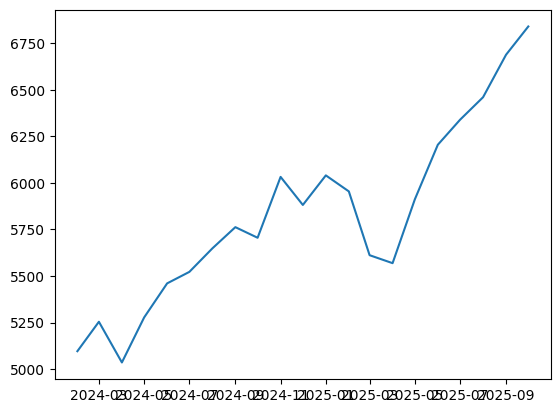

In [126]:
plt.figure()

plt.plot(aranceles_trump['Date'], aranceles_trump['Close'])

plt.show()

In [127]:
print(100/1500)

0.06666666666666667


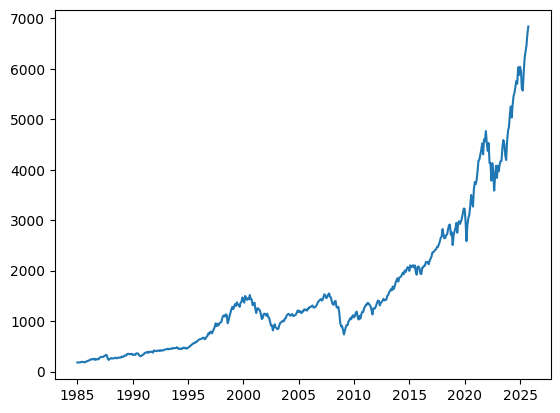

In [128]:
plt.figure()

plt.plot(df['Date'], df['Close'])

plt.show()